In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

In [2]:
batch_size = 64
num_epochs = 30
early_stop_patience = 5
data_dir = '../data/cifar10'

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjusted dimensions here
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Adjusted dimensions here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Devuelve logits sin procesar

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root= data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0
best_epoch = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(acc)

    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Train Acc: {acc:.4f} | Test Acc: {val_acc:.4f}")

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best model was from epoch {best_epoch}.")
            break


Epoch 01 | Train Loss: 1.6130 | Test Loss: 1.3556 | Train Acc: 0.4257 | Test Acc: 0.5216
Epoch 02 | Train Loss: 1.2788 | Test Loss: 1.2299 | Train Acc: 0.5515 | Test Acc: 0.5668
Epoch 03 | Train Loss: 1.1471 | Test Loss: 1.1012 | Train Acc: 0.6005 | Test Acc: 0.6138
Epoch 04 | Train Loss: 1.0553 | Test Loss: 1.0778 | Train Acc: 0.6337 | Test Acc: 0.6232
Epoch 05 | Train Loss: 0.9850 | Test Loss: 0.9920 | Train Acc: 0.6611 | Test Acc: 0.6529
Epoch 06 | Train Loss: 0.9264 | Test Loss: 0.9947 | Train Acc: 0.6790 | Test Acc: 0.6600
Epoch 07 | Train Loss: 0.8770 | Test Loss: 0.9713 | Train Acc: 0.6968 | Test Acc: 0.6618
Epoch 08 | Train Loss: 0.8347 | Test Loss: 0.9129 | Train Acc: 0.7122 | Test Acc: 0.6852
Epoch 09 | Train Loss: 0.7951 | Test Loss: 0.9084 | Train Acc: 0.7274 | Test Acc: 0.6852
Epoch 10 | Train Loss: 0.7589 | Test Loss: 0.8714 | Train Acc: 0.7402 | Test Acc: 0.6966
Epoch 11 | Train Loss: 0.7292 | Test Loss: 0.8883 | Train Acc: 0.7509 | Test Acc: 0.6913
Epoch 12 | Train Loss

In [7]:
if best_model is not None:
    model.load_state_dict(best_model)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final CIFAR10 Test Accuracy (best model): {correct / total:.4f}")


✅ Final CIFAR10 Test Accuracy (best model): 0.7314


In [8]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.71      0.76      1000
  automobile       0.86      0.82      0.84      1000
        bird       0.64      0.62      0.63      1000
         cat       0.60      0.50      0.55      1000
        deer       0.63      0.76      0.69      1000
         dog       0.61      0.67      0.64      1000
        frog       0.74      0.83      0.79      1000
       horse       0.81      0.75      0.77      1000
        ship       0.82      0.85      0.83      1000
       truck       0.83      0.80      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



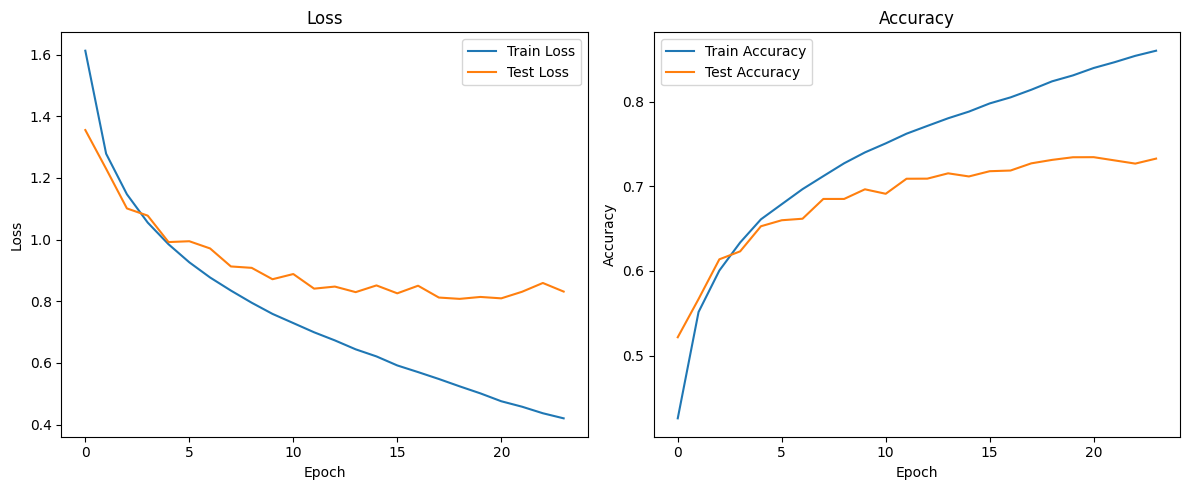

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[1.6130169985239462, 1.2788450641705251, 1.1471311941628566, 1.0552762752908575, 0.9849588267333672, 0.926357340019987, 0.8770300450989658, 0.8346532400306839, 0.795145061391089, 0.7589364294200907, 0.7291686893500331, 0.6992804796799369, 0.672918118403086, 0.643955105291608, 0.6209452800890979, 0.5916880895490841, 0.5700810264862711, 0.5476671966445416, 0.5238116705204214, 0.5009558717231921, 0.47545672040385056, 0.457732653431118, 0.43651013949033246, 0.4199928819104229]
[1.3555694810903756, 1.229873965879914, 1.1012102376883197, 1.0778030312744675, 0.9920386504975094, 0.9947323233458647, 0.9713046922805203, 0.9129059815862376, 0.9083640966445777, 0.8714185562103417, 0.888283704496493, 0.8408867933188274, 0.8475683380843727, 0.8295516684936111, 0.8513628525339114, 0.8256921422709326, 0.8503649219585832, 0.8119914898067523, 0.8077039547786591, 0.8139477216514053, 0.8094081603417731, 0.8307574533732833, 0.8592658974942128, 0.8313928404051787]
[0.4257, 0.55146, 0.60052, 0.63368, 0.6611,